# MLP 120
Train on medium, evaluate on all

In [1]:
#from google.colab import drive
#PATH='/content/drive/'
#drive.mount(PATH)
#DATAPATH=PATH+'My Drive/data/'
#PC_FILENAME = DATAPATH+'pcRNA.fasta'
#NC_FILENAME = DATAPATH+'ncRNA.fasta'
#PC_FILENAME = 'pcRNA.fasta'
#NC_FILENAME = 'ncRNA.fasta'
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'

EPOCHS=5
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP201'
NEURONS=16


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time

dt='float32'
tf.keras.backend.set_floatx(dt)



## Load and partition sequences

In [3]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [4]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [5]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    #X_train_all
    #print(type(X_train_all))
    #print(X_train_all.shape)
    #print(X_train_all.iloc[0])
    #print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    #print("transform...")
    # From pandas dataframe to numpy to list to numpy
    print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    print(type(X_train_kmers))
    #print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [6]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)

## Build model

In [7]:
def build_model(maxlen):
    act="sigmoid"

    embed_layer  = keras.layers.Embedding(
        VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    
    dense1_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt,input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation=act,dtype=dt)

    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    #mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

## Cross validation

In [15]:
def do_cross_validation(X,y,model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]

        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)
                        
        fold += 1
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
    return model

In [16]:
def just_train(model,X_train,y_train,maxlen):
    print("FIT")
    start_time=time.time()
    history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
            )  # no validation data
    end_time=time.time()
    elapsed_time=(end_time-start_time)
    print("Train %d epochs, %d sec"%(EPOCHS,elapsed_time))

    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

    #scores = model.evaluate(X_valid, y_valid, verbose=0)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #cv_scores.append(scores[1] * 100)  
    #print()
    #print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
    return model

## Load

In [17]:
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)

nc_seq=None
pc_seq=None

print("Ready: train_set")
#train_set

MINLEN=200
MAXLEN=1000

print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once


Load data from files.
Ready: train_set
Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                96        
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None


## Len 200-1Kb

In [18]:
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    print(slice)
    return slice

print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("ok")

Data prep
       seqnum  class                                           sequence  \
0           1      0  TCATCAGTCCAAAGTCCAGCAGTTGTCCCTCCTGGAATCCGTTGGC...   
1           2      0  GGGGTTTCGGGGCTGTGGACCCTGTGCCAGGAAAGGAAGGGCGCAG...   
3           4      0  TTGGTTTCCCAGGGGGCAGTGCTGAGCTCTTTGCCAGTGGGAAATG...   
4           5      0  TCGGTAGCTTCCGAGGCTCTGCGGGAGAATCCGTTTCCTGGCCGTA...   
5           6      0  ATTCAAATGGGCCCTGCTGCCAAGCCTTTTTTTTTTTTTTTTAACA...   
...       ...    ...                                                ...   
15992   15993      1  ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...   
15993   15994      1  ATGACCCACCAATCACATGCCTATCATATAGTAAAACCCAGCCCAT...   
15994   15995      1  ATAAACTTCGCCTTAATTTTAATAATCAACACCCTCCTAGCCTTAC...   
15995   15996      1  ATGCCCCTCATTTACATAAATATTATACTAGCATTTACCATCTCAC...   
15998   15999      1  ATGATGTATGCTTTGTTTCTGTTGAGTGTGGGTTTAGTAATGGGGT...   

       seqlen  
0         535  
1         590  
3         323  
4         821  
5        

Data reshape
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
Cross valiation
FIT
Epoch 1/5
453/453 [==============================] - 1s 2ms/step - loss: 0.6595 - accuracy: 0.6208 - val_loss: 0.6398 - val_accuracy: 0.6530
Epoch 2/5
453/453 [==============================] - 1s 2ms/step - loss: 0.6418 - accuracy: 0.6397 - val_loss: 0.6228 - val_accuracy: 0.6530
Epoch 3/5
453/453 [==============================] - 1s 2ms/step - loss: 0.6183 - accuracy: 0.6469 - val_loss: 0.5937 - val_accuracy: 0.7058
Epoch 4/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5929 - accuracy: 0.6792 - val_loss: 0.5660 - val_accuracy: 0.7064
Epoch 5/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5812 - accuracy: 0.6882 - val_loss: 0.5567 - val_accuracy: 0.7188
Fold 1, 5 epochs, 4 sec


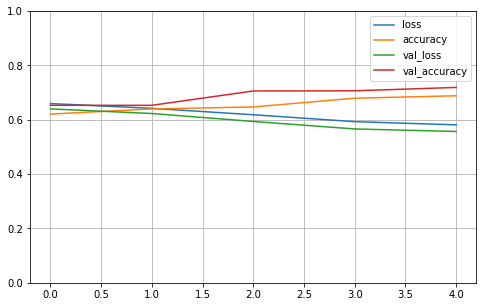

accuracy: 71.88%
FIT
Epoch 1/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5735 - accuracy: 0.6953 - val_loss: 0.5717 - val_accuracy: 0.6915
Epoch 2/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5695 - accuracy: 0.6980 - val_loss: 0.5673 - val_accuracy: 0.6983
Epoch 3/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5659 - accuracy: 0.7008 - val_loss: 0.5651 - val_accuracy: 0.7033
Epoch 4/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5624 - accuracy: 0.7070 - val_loss: 0.5606 - val_accuracy: 0.7058
Epoch 5/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5590 - accuracy: 0.7083 - val_loss: 0.5584 - val_accuracy: 0.7052
Fold 2, 5 epochs, 3 sec


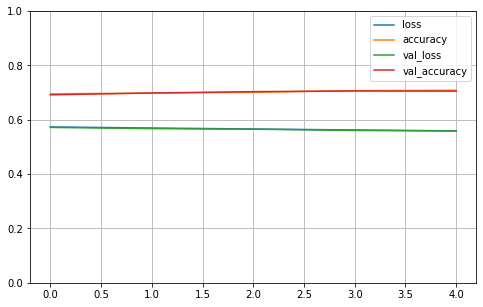

accuracy: 70.52%
FIT
Epoch 1/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5566 - accuracy: 0.7114 - val_loss: 0.5497 - val_accuracy: 0.7163
Epoch 2/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5545 - accuracy: 0.7131 - val_loss: 0.5454 - val_accuracy: 0.7182
Epoch 3/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5524 - accuracy: 0.7152 - val_loss: 0.5437 - val_accuracy: 0.7182
Epoch 4/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5509 - accuracy: 0.7170 - val_loss: 0.5413 - val_accuracy: 0.7200
Epoch 5/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5493 - accuracy: 0.7162 - val_loss: 0.5398 - val_accuracy: 0.7182
Fold 3, 5 epochs, 3 sec


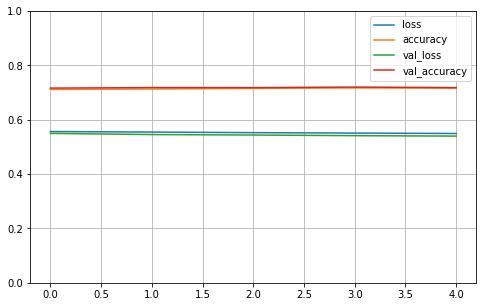

accuracy: 71.82%
FIT
Epoch 1/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5479 - accuracy: 0.7168 - val_loss: 0.5403 - val_accuracy: 0.7306
Epoch 2/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5467 - accuracy: 0.7193 - val_loss: 0.5407 - val_accuracy: 0.7306
Epoch 3/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.7177 - val_loss: 0.5377 - val_accuracy: 0.7269
Epoch 4/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5456 - accuracy: 0.7190 - val_loss: 0.5377 - val_accuracy: 0.7256
Epoch 5/5
453/453 [==============================] - 1s 2ms/step - loss: 0.5453 - accuracy: 0.7189 - val_loss: 0.5365 - val_accuracy: 0.7300
Fold 4, 5 epochs, 4 sec


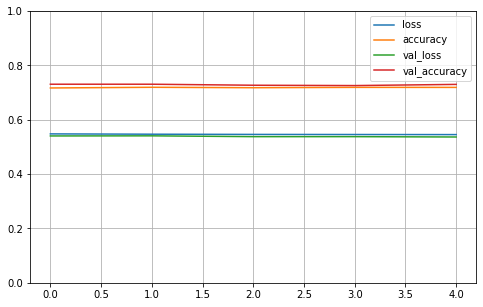

accuracy: 73.00%
FIT
Epoch 1/5
335/453 [=====================>........] - ETA: 0s - loss: 0.5446 - accuracy: 0.7226

In [ ]:
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)
print ("Cross valiation")
model1 = do_cross_validation(X_train,y_train,model)  # should use model_clone() ?
model1.save(FILENAME+'.short.model')
print ("Done")

In [ ]:
def evaluate(model,min,max):
    print("Evaluate on lengths %d to %d"%(min,max))
    print("slice...")
    subset=make_slice(train_set,min,max)
    print("kmers...")
    (X_valid,y_valid)=make_kmers(max,subset)
    print("frequencies...")
    X_valid=make_frequencies(X_valid)
    print("evaluate....")
    scores = model.evaluate(X_valid, y_valid, verbose=1)  # valid = train, expect 100%
    print("Evaluated on lengths %d to %d"%(min,max))
    print("%s: %.2f%%\n" % (model.metrics_names[1], scores[1]*100))
